In [7]:
! pip install datasets wordcloud scikit-learn seaborn

import sys
from datasets import load_dataset
import pandas as pd
from pathlib import Path as p
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import seaborn as sns


PATH = "/home/xd/Documents/python_codes/ML_Notebooks"
sys.path.append(PATH)


from ML_notebook_config import DATASETS, SENTIMENTAL_ANALYSIS_HF_DATASET

ds = load_dataset(SENTIMENTAL_ANALYSIS_HF_DATASET)

In [28]:
df = pd.DataFrame(ds["train"])

print(df["label"].unique())
label_map = {'neutral': 1.0, 'joy': 2.0, 'anger': 3.0, 'surprise': 4.0, 'sadness': 5.0, 'fear': 6.0, 'love': 7.0}
reverse_label_map = {1.0: 'neutral', 2.0: 'joy', 3.0: 'anger', 4.0: 'surprise', 5.0: 'sadness', 6.0: 'fear', 7.0: 'love'}
df['mapped_label'] = df['label'].map(label_map)
labels = df["label"].unique()

# saving the dataframe to csv locally
df.to_csv(p.joinpath(DATASETS, f"{SENTIMENTAL_ANALYSIS_HF_DATASET.replace("/", "_")}.csv"))

['neutral' 'joy' 'anger' 'surprise' 'sadness' 'fear' 'love']


In [9]:
label_wise_wordcloud = {}

for label in labels:
  wc = WordCloud(stopwords=STOPWORDS).generate(" ".join(df[df["label"] == label]["sentence"]))
  label_wise_wordcloud.update({label: wc})

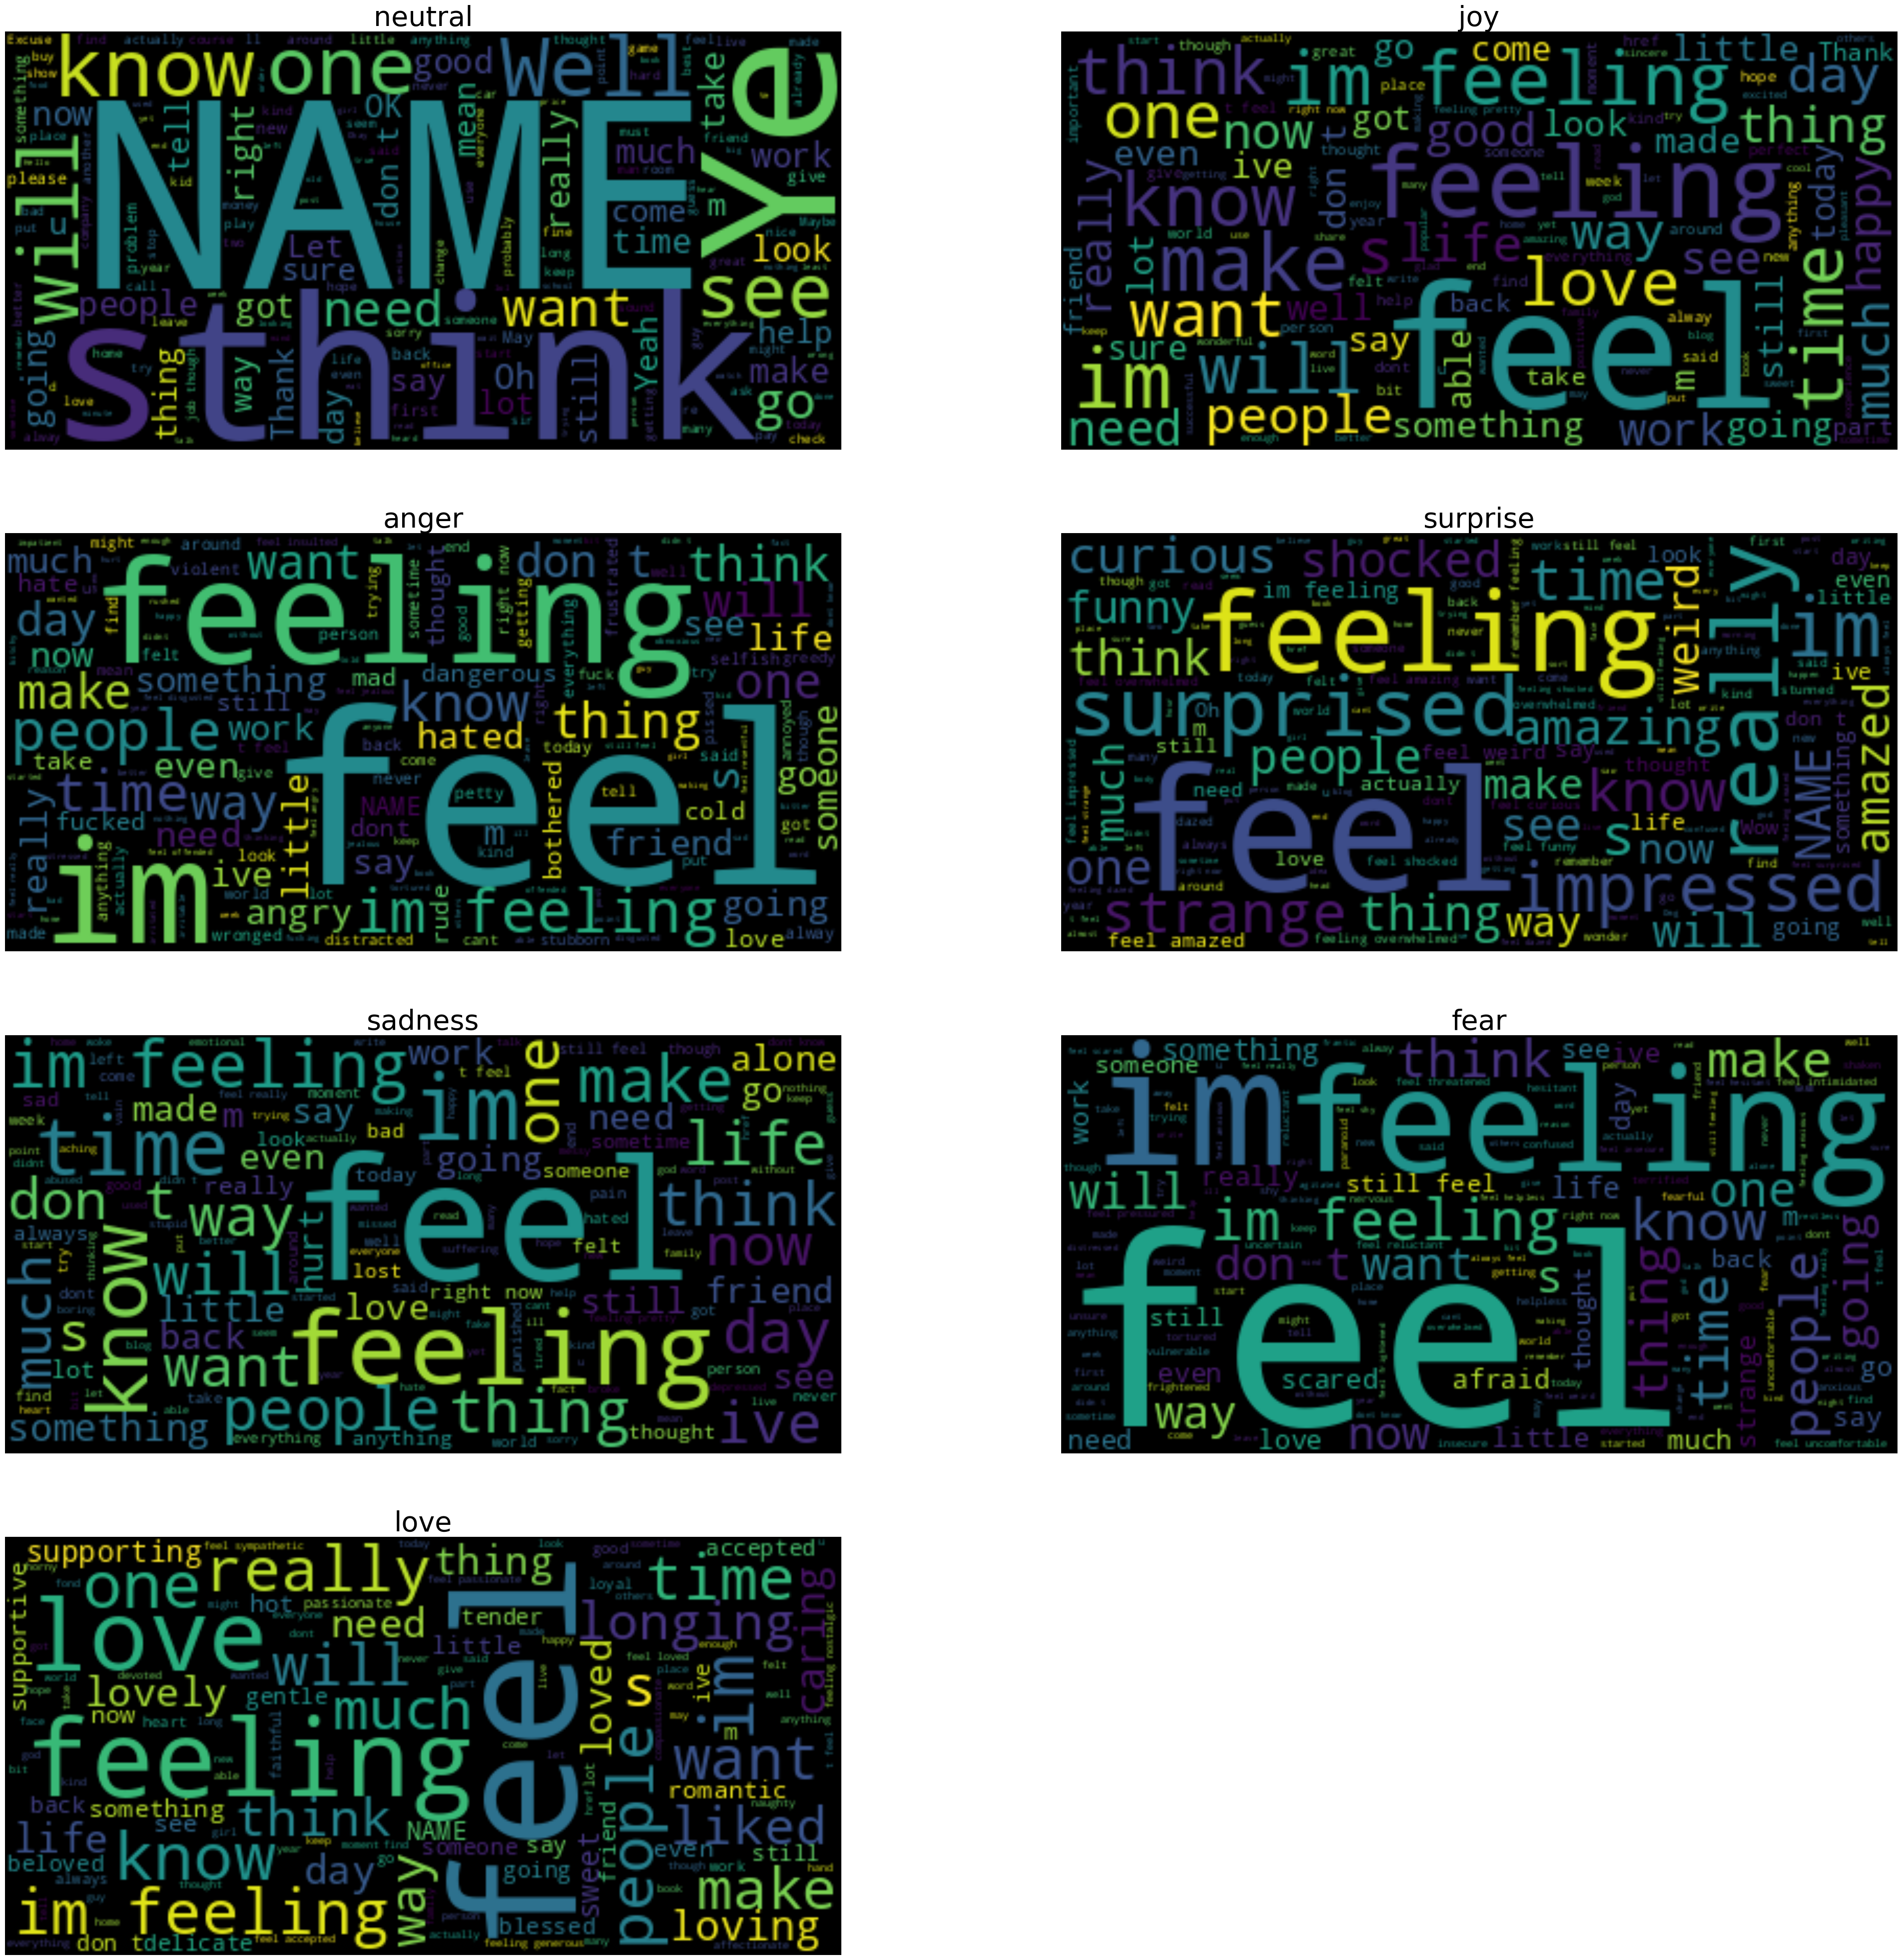

In [10]:
plt.figure(figsize=(50, 50))
for i, label in enumerate(label_wise_wordcloud):
	plt.subplot(4, 2, i+1)
	plt.title(label, fontsize=40)
	plt.imshow(label_wise_wordcloud[label], interpolation='bilinear')
	plt.axis("off")
plt.show()

In [11]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["sentence"])
y = df["mapped_label"]


In [12]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression
model = LogisticRegression(multi_class='ovr')
model.fit(X, y)

/home/xd/Documents/python_codes/ML_Notebooks/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [13]:
print(model.coef_.shape)

(7, 1000)


In [14]:
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

top_mapped_coefs = {}

for i, label in enumerate(model.classes_):
	word_weights = zip(feature_names, coefs[i])
  
	sorted_weights = sorted(word_weights, key=lambda x: x[1], reverse=True)
	print(f"\nTop words for emotion '{label}':")
	for word, weight in sorted_weights[:10]:
		print(f"{word}: {weight:.4f}")
	
	top_mapped_coefs.update({label: sorted_weights})


Top words for emotion '1.0':
excuse: 2.4734
office: 1.7662
check: 1.7225
tired: 1.6006
please: 1.5596
afternoon: 1.4700
better: 1.4544
they: 1.2360
company: 1.2225
need: 1.1688

Top words for emotion '2.0':
sincere: 12.8778
reassured: 12.3704
resolved: 12.3379
vital: 12.0992
mellow: 11.9486
invigorated: 11.7077
divine: 11.6103
welcomed: 11.5927
virtuous: 11.5698
respected: 11.5613

Top words for emotion '3.0':
dissatisfied: 15.3800
envious: 14.9962
wronged: 14.8448
greedy: 14.6488
rebellious: 13.7835
rushed: 13.1870
resentful: 13.1577
impatient: 12.8597
insulted: 12.8173
distracted: 12.8115

Top words for emotion '4.0':
amazed: 17.3172
shocked: 16.6064
impressed: 16.1422
curious: 14.7478
surprised: 13.1205
funny: 10.7575
overwhelmed: 9.1175
amazing: 8.8801
strange: 8.6304
weird: 8.3116

Top words for emotion '5.0':
unwelcome: 13.6342
groggy: 13.4433
burdened: 13.3680
vain: 13.0151
unimportant: 13.0127
jaded: 12.9048
disheartened: 12.8714
sentimental: 12.8506
troubled: 12.8271
homesick

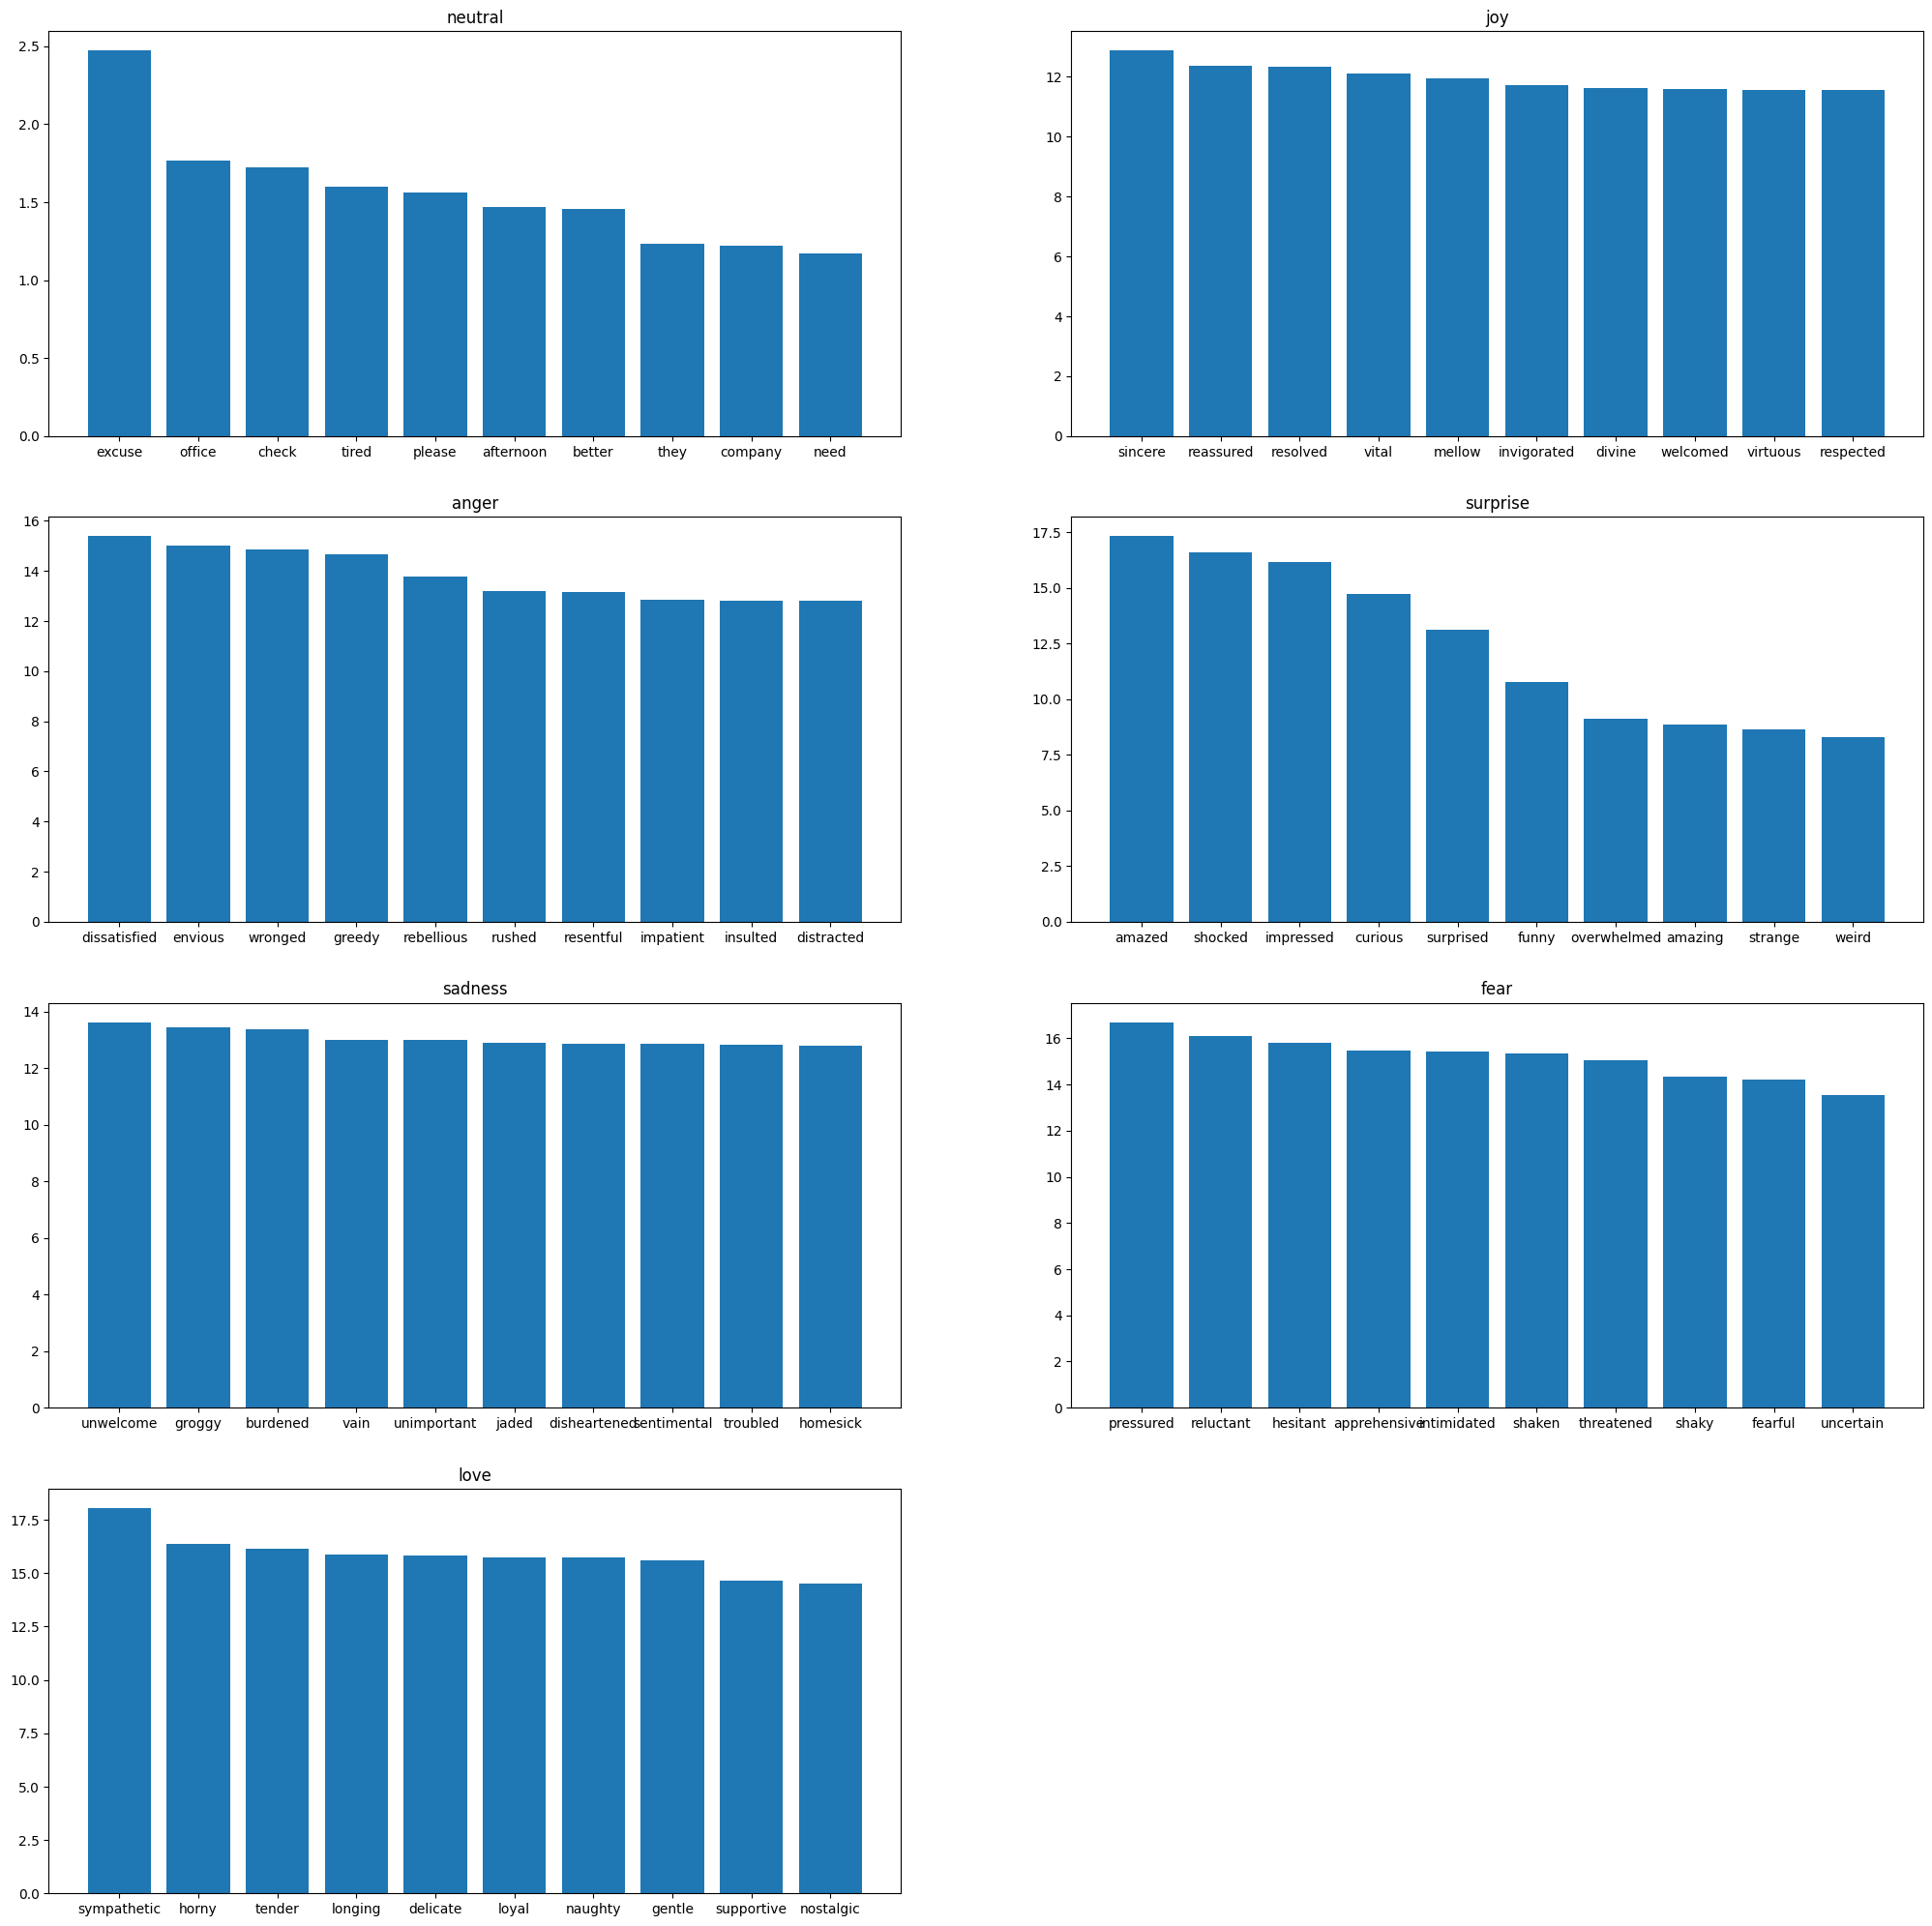

In [31]:
plt.figure(figsize=(25, 25))
for i, (label, coef_list) in enumerate(top_mapped_coefs.items()):
	coefs = [c[1] for c in coef_list][:10]
	words = [c[0] for c in coef_list][:10]
	plt.subplot(4, 2, i+1)
	plt.bar(words, coefs)
	plt.title(reverse_label_map.get(label))
  